In [1]:
%env CUDA_VISIBLE_DEVICES=0
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import imageio
import moviepy.editor as mpy

BATCH_SIZE = 500
SAMPLE_COL = 16
SAMPLE_ROW = 16
SAMPLE_NUM = SAMPLE_COL * SAMPLE_ROW
IMG_H = 64
IMG_W = 64
IMG_C = 3
IMG_SHAPE = (IMG_H, IMG_W, IMG_C)
Z_DIM = 128
BUF = 65536
DC_LR = 2.5e-04
DC_EPOCH = 256
W_LR = 2.0e-04
IW_LR = 1e-4
W_EPOCH = 128
BZ = (BATCH_SIZE, Z_DIM)
WClipLo = -0.01
WClipHi = 0.01

env: CUDA_VISIBLE_DEVICES=0


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit = 0x2400)])

In [3]:
# need sometime to load imgs

import os
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

dir_data      = "img_align_celeba_png/"
Ntrain        = 200000 
Ntest         = 100
nm_imgs       = np.sort(os.listdir(dir_data))
## name of the jpg files for training set
nm_imgs_train = nm_imgs[:Ntrain]
## name of the jpg files for the testing data
nm_imgs_test  = nm_imgs[Ntrain:Ntrain + Ntest]
img_shape     = (64, 64, 3)

def get_npdata(nm_imgs_train):
    X_train = []
    for i, myid in enumerate(nm_imgs_train):
        image = load_img(dir_data + "/" + myid,
                         target_size=img_shape[:2])
        image = img_to_array(image)/255.0
        X_train.append(image)
    X_train = np.array(X_train)
    return(X_train)

X_train = get_npdata(nm_imgs_train)
print("X_train.shape = {}".format(X_train.shape))

X_test  = get_npdata(nm_imgs_test)
print("X_test.shape = {}".format(X_test.shape))

X_train.shape = (200000, 64, 64, 3)
X_test.shape = (100, 64, 64, 3)


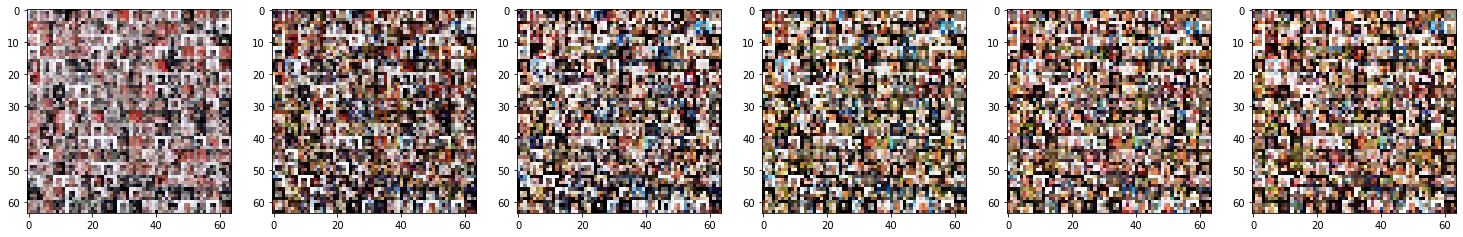

In [4]:
fig = plt.figure(figsize=(30,10))
nplot = 7
for count in range(1,nplot):
    ax = fig.add_subplot(1,nplot,count)
    ax.imshow(X_train[count])
plt.show()

In [5]:
dsTrain = tf.data.Dataset.from_tensor_slices(X_train).shuffle(BUF).batch(BATCH_SIZE, True)

print(X_train.shape)
print(dsTrain)

(200000, 64, 64, 3)
<BatchDataset shapes: (500, 64, 64, 3), types: tf.float32>


In [6]:
# Utility function
def utPuzzle(imgs, row, col, path = None):
    h, w, c = imgs[0].shape
    out = np.zeros((h * row, w * col, c), np.uint8)
    for n, img in enumerate(imgs):
        j, i = divmod(n, col)
        out[j * h : (j + 1) * h, i * w : (i + 1) * w, :] = img
    if path is not None : imageio.imwrite(path, out)
    return out

In [7]:
def GAN(sp, zd):
    # Shape
    xh, xw, xc = sp
    zh = xh // 4
    zw = xw // 4
        
    # Model
    return keras.Sequential([
        keras.layers.Dense(units  =  1024, input_shape = (zd,)),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Dense(units  =  zh * zw << 8),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Reshape(target_shape = (zh, zw, 256)),
        keras.layers.Conv2DTranspose(
            filters = 32,
            kernel_size = 5,
            strides = 2,
            padding = "SAME"
        ),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Conv2DTranspose(
            filters = xc,
            kernel_size = 5,
            strides = 2,
            padding = "SAME",
            activation = keras.activations.sigmoid
        ),
    ]), keras.Sequential([
        keras.layers.Conv2D(
            filters = 32,
            kernel_size = 5,
            strides = (2, 2),
            padding = "SAME",
            input_shape = sp,
        ),
        keras.layers.LeakyReLU(),
        #keras.layers.Dropout(0.3),
        keras.layers.Conv2D(
            filters = 128,
            kernel_size = 5,
            strides = (2, 2),
            padding = "SAME"
        ),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(),
        #keras.layers.Dropout(0.3),
        keras.layers.Flatten(),
        keras.layers.Dense(units  =  1024),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(),
        keras.layers.Dense(units  =  1),
    ])

s = tf.random.normal([SAMPLE_NUM, Z_DIM])

In [8]:
WG, WD = GAN(IMG_SHAPE, Z_DIM)
opg = keras.optimizers.Adam(IW_LR, beta_1=0.0, beta_2=0.9)
opd = keras.optimizers.Adam(IW_LR, beta_1=0.0, beta_2=0.9)
LAMBDA = 10

@tf.function
def WGTrain(c1, epsilon):
    z = tf.random.normal((c1.shape[0], Z_DIM))
    
    with tf.GradientTape(persistent=True) as tpg:
        x_bar = WG(z, training = True)
        x = c1
        x_hat = epsilon * x + (1 - epsilon) * x_bar
        
        Dwx_hat = WD(x_bar, training = True) 
        Dwx = WD(x, training = True)
        tmp = WD(x_hat, training = True)
        
        grads = tpg.gradient(tmp, x_hat)
        slopes  = tf.sqrt(tf.reduce_sum(tf.square(grads)))
        gradient_penalty = tf.reduce_mean(((slopes-1.)**2))
        ld = tf.reduce_mean(Dwx_hat) - tf.reduce_mean(Dwx) + LAMBDA * gradient_penalty
        lg = - tf.reduce_mean(Dwx_hat)
    
    gg = tpg.gradient(lg, WG.trainable_variables)
    opg.apply_gradients(zip(gg, WG.trainable_variables))
    
    return lg, ld

@tf.function
def WDTrain(c1, epsilon):
    z = tf.random.normal((c1.shape[0], Z_DIM))
    
    with tf.GradientTape(persistent=True) as tpd:
        x_bar = WG(z, training = True)
        x = c1
        x_hat = epsilon * x + (1 - epsilon) * x_bar
        
        Dwx_hat = WD(x_bar, training = True) 
        Dwx = WD(x, training = True)
        tmp = WD(x_hat, training = True)
        
        grads = tpd.gradient(tmp, x_hat)
        slopes  = tf.sqrt(tf.reduce_sum(tf.square(grads)))
        gradient_penalty = tf.reduce_mean(((slopes-1.)**2))
        ld = tf.reduce_mean(Dwx_hat) - tf.reduce_mean(Dwx) + LAMBDA * gradient_penalty
        lg = - tf.reduce_mean(Dwx_hat)
    
    gd = tpd.gradient(ld, WD.trainable_variables)
    opd.apply_gradients(zip(gd, WD.trainable_variables))
    
    return lg, ld

WTrain = (
    WDTrain,
    WDTrain,
    WDTrain,
    WDTrain,
    WDTrain,
    WGTrain
)

WCritic = len(WTrain)

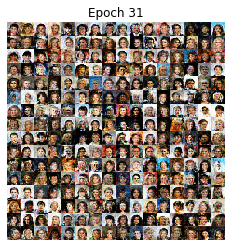

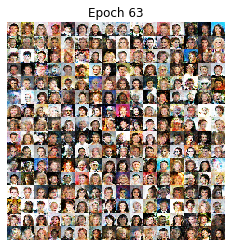

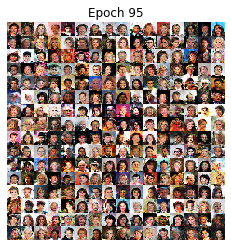

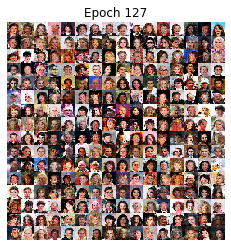

In [9]:
wlg = [None] * W_EPOCH
wld = [None] * W_EPOCH
wsp = [None] * W_EPOCH
rsTrain = float(BATCH_SIZE) / float(len(X_train))
ctr = 0
for ep in range(W_EPOCH):
    lgt = 0.0
    ldt = 0.0
    for c1 in dsTrain:
        epsilon = np.random.uniform(low=0.0, high=1.0)
        epsilon = tf.convert_to_tensor(epsilon, dtype=tf.float32)   
        lg, ld = WTrain[ctr](c1,epsilon)
        ctr += 1
        lgt += lg.numpy()
        ldt += ld.numpy()
        if ctr == WCritic : ctr = 0
    wlg[ep] = lgt * rsTrain
    wld[ep] = ldt * rsTrain
    
    out = WG(s, training = False)
    img = utPuzzle(
        (out * 255.0).numpy().astype(np.uint8),
        SAMPLE_COL,
        SAMPLE_ROW,
        "imgs/%04d.png" % ep
    )
    wsp[ep] = img
    if ep & 0x1F == 0x1F:
        
        plt.imshow(img[..., :])
        plt.axis("off")
        plt.title("Epoch %d" % ep)
        plt.show()

# gif

In [10]:
def utMakeGif(imgs, fname, duration):
    n = float(len(imgs)) / duration
    clip = mpy.VideoClip(lambda t : imgs[int(n * t)], duration = duration)
    clip.write_gif(fname, fps = n)

In [11]:
utMakeGif(np.array(wsp), "imgs/improved_wgan.gif", duration = 2)


[MoviePy] Building file imgs/improved_wgan.gif with imageio


 99%|█████████▉| 128/129 [01:04<00:00,  1.97it/s]


# loss curve of discriminator and generator

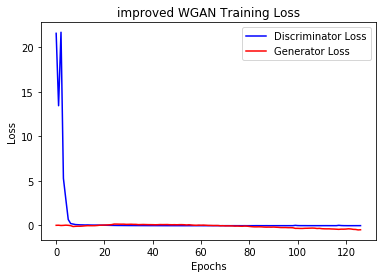

In [13]:
plt.plot(range(W_EPOCH-5), wld[5:], color = "blue", label = "Discriminator Loss")
plt.plot(range(W_EPOCH-5), wlg[5:], color = "red", label = "Generator Loss")
plt.legend(loc = "upper right")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("improved WGAN Training Loss")
plt.show()

# Report

一、修改的參數:
1. IMG_SHAPE 改成 (64,64,3)
2. BATCH_SIZE 改成 500
3. 依照 improved WGAN 更改成 Adam optimizer 和設定 learning rate 及 beta 值等等
4. EPOCH = 128
5. 讀 celebA dataset

二、修改 WGTrain 、 WDTrain :
1. 多讀一個 uniform distribution range = [0,1] 的 epsilon 
2. 實作 gradient penalty

(執行的時候要多建一個 imgs 資料夾來存照片和建立好的gif)